 # please re-start kernel if these packages are installed for the first time

In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs 
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget,fetch_data
import pandas as pd

# user inputs

In [4]:
is_close_to_opt = True
# budget = None # None for auto determination
budget = 20 
# check and adjust decision parameters and objectives later

# this template is for 
### objFuncs: v1.0.3
### pyBO: v1.0.1

In [6]:
import objFuncs
from objFuncs.util import read_BPMoverview_snapshot
from objFuncs.preset import get_preset, get_tolerance
from pyBO import pyBO

objFuncs version: 1.0.3. updated on 2024-03-11
pyBO version: 1.0.1. updated on 2024-03-15


# check machineIO, source and beam  

In [7]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 5.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = 0.5
# objFuncs._global_machineIO.view()

In [8]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS1 124Xe26 A/Q= 4.769230769230769


In [9]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][pyBO][LS1][CA]match_phase_to_snapshot'
fname

'20240317_1115[124Xe26][pyBO][LS1][CA]match_phase_to_snapshot'

# preprare decision ( control knob)

In [10]:
decision_CSETs=['FE_MEBT:RFC_D1066:PHA_CSET'   , 'FE_MEBT:RFC_D1107:PHA_CSET'   ]
decision_RDs = ['FE_MEBT:RFC_D1066:PHA_RD_CAVS', 'FE_MEBT:RFC_D1107:PHA_RD_CAVS']
decision_tols = [0.05, 0.05]
ave,_ = fetch_data(decision_CSETs,0.1)


# this is local bounds (we don't do glol optim for cav phase)
decision_min = ave - 1
decision_max = ave + 1
local_bounds = np.array(list(zip(decision_min, decision_max)))

pd.DataFrame(np.array([ave,decision_min,decision_max,decision_tols]).T,
             index=decision_CSETs, 
             columns=['current value','min','max','tol'])

,current value,min,max,tol
FE_MEBT:RFC_D1066:PHA_CSET,8.873721,6.873721,10.873721,0.05
FE_MEBT:RFC_D1107:PHA_CSET,23.710006,21.710006,25.710006,0.05


# preprare objective function

In [12]:
BPM_snapshot_fname = '20230527_1926_124Xe26_3q_216p5MeVu.bpm'
objective_goal = read_BPMoverview_snapshot(BPM_snapshot_fname,Dnum_from=1100,Dnum_to=2000)
objective_goal

{'FE_MEBT:BPM_D1111:PHASE_RD': 20.03563586437771,
 'LS1_CA01:BPM_D1129:PHASE_RD': -24.88891657562583,
 'LS1_CA01:BPM_D1144:PHASE_RD': 70.50081973425036,
 'LS1_WA01:BPM_D1155:PHASE_RD': 45.09249625566684,
 'LS1_CA02:BPM_D1163:PHASE_RD': -77.51095068086866,
 'LS1_CA02:BPM_D1177:PHASE_RD': -88.1575438731834,
 'LS1_WA02:BPM_D1188:PHASE_RD': -62.945785948392086,
 'LS1_CA03:BPM_D1196:PHASE_RD': -75.72410528489884,
 'LS1_CA03:BPM_D1211:PHASE_RD': 84.67290439799982,
 'LS1_WA03:BPM_D1222:PHASE_RD': 55.93226695976357,
 'LS1_CB01:BPM_D1231:PHASE_RD': -1.5951664967026082,
 'LS1_CB01:BPM_D1251:PHASE_RD': 60.30428453604858,
 'LS1_CB01:BPM_D1271:PHASE_RD': 66.08025139760515,
 'LS1_WB01:BPM_D1286:PHASE_RD': 68.46770436361084,
 'LS1_CB02:BPM_D1295:PHASE_RD': 89.00106152550906,
 'LS1_CB02:BPM_D1315:PHASE_RD': 26.641297283585992,
 'LS1_CB02:BPM_D1335:PHASE_RD': 62.99144507284767,
 'LS1_WB02:BPM_D1350:PHASE_RD': -80.19505028272599,
 'LS1_CB03:BPM_D1359:PHASE_RD': 19.72960808508179,
 'LS1_CB03:BPM_D1379:PH

In [14]:
objective_norm = {k:1. for k in objective_goal.keys()}
objective_weight = {k:1. for k in objective_goal.keys()}

In [13]:
import numpy as np
np.log(5*4)

2.995732273553991

In [15]:
obj = objFuncs.objFuncGoals(
    decision_CSETs=decision_CSETs,
    decision_RDs = decision_RDs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    objective_p_order = 4,
    apply_bilog = True,
)

======== class info ========
init_time: 2024-03-17 11:15:36.089553
class_hierarchy: [
    objFuncGoals, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f34bcfc6950>
decision_CSETs: [
    FE_MEBT:RFC_D1066:PHA_CSET, FE_MEBT:RFC_D1107:PHA_CSET]
decision_min: [ 6.87372086 21.71000607]
decision_max: [10.87372086 25.71000607]
decision_bounds: [[ 6.87372086 10.87372086]
 [21.71000607 25.71000607]]
decision_RDs: [
    FE_MEBT:RFC_D1066:PHA_RD_CAVS, FE_MEBT:RFC_D1107:PHA_RD_CAVS]
decision_tols: [0.05 0.05]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [ 8.87372086 23.71000607]
plot_time_val: <class 'objFuncs.util.plot_time_val'>
plot_obj_history: <class 'objFuncs.util.plot_obj_history'>
objective_weight:
    FE_MEBT:BPM_D1111:PHASE_RD: 0.017857142857142856
    LS1_CA01:BPM_D1129:PHASE_RD: 0.017857142857142856
    LS1_CA01:BPM_D1144:PHASE_RD: 0.017857142857142856
    LS1_WA01:BPM_D1155:PHASE

# run Optim

In [16]:
ctrBO = pyBO.bo_controller(obj,
                           local_optimization = is_close_to_opt,
                           local_bounds = local_bounds,
                           )

init will random sample with the followings info:
  n_init: 2


,min,max
FE_MEBT:RFC_D1066:PHA_CSET,8.573721,9.173721
FE_MEBT:RFC_D1107:PHA_CSET,23.410006,24.010006


UnboundLocalError: cannot access local variable 'train_y' where it is not associated with a value

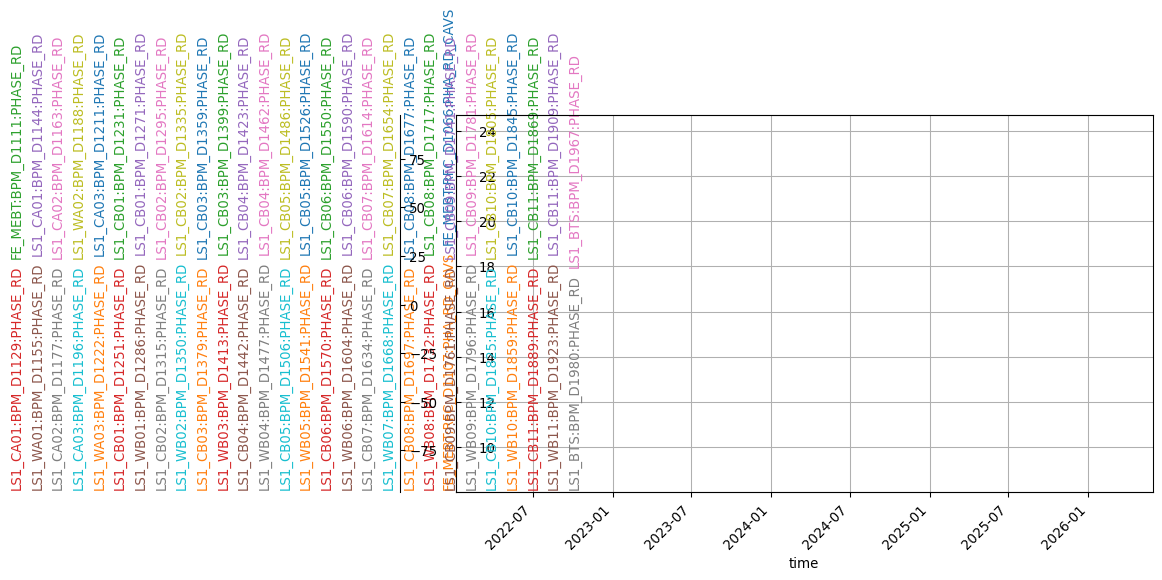

In [17]:
# optimize
ctrBO.init()
ctrBO.optimize(budget)

### set to best solution 

In [ ]:
x_best,y_best_old = ctrBO.bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

In [ ]:
now1 = datetime.datetime.now()
now1str = now1.strftime('%Y%m%d_%H%M')
time_delta = now1 - now0
print("time took:",str(time_delta.total_seconds()/60)[:4],'min')

# Visualize Surrogate model

In [ ]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4

t0 = time.monotonic()
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fixed_values_for_each_dim=fixed_values_for_each_dim,
                                            fig=fig,ax=ax_);
        ax_.scatter(obj.x0[2*n],obj.x0[2*n+1],color='k',label='initial')
        ax_.scatter(x_best[2*n],x_best[2*n+1],color='r',label='optimum')
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()

    
print('time took: ',time.monotonic()-t0)